In [2]:
pip install opencv-python

     |████████████████████████████████| 46.3 MB 76.2 MB/s eta 0:00:01    |████████████████████▉           | 30.2 MB 5.1 MB/s eta 0:00:04     |█████████████████████████████▌  | 42.6 MB 76.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

     |████████████████████████████████| 217.5 MB 80 kB/s s eta 0:00:01  |█                               | 7.3 MB 3.5 MB/s eta 0:01:01█████████▍              | 118.3 MB 64.7 MB/s eta 0:00:02     |███████████████████████▏        | 157.7 MB 7.9 MB/s eta 0:00:08
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 4.3 MB 22.3 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 44.5 MB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 69.0 MB/s eta 0:00:01
     |████████████████████████████████| 961 kB 12.3 MB/s eta 0:00:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
     |████████████████████████████████| 1.4 MB 10.7 MB/s eta 0:00:01
  Using cached astunparse-1.6.3-py2.py3-none-a

In [6]:
# Load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
# from skimage.measure import compare_ssim
from skimage.metrics import structural_similarity as ssim
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
# import mlflow
# import mlflow.keras
# import mlflow.tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

We will upload the data to Azure Blob Storage and then mount to Azure Databricks DBFS

In [8]:
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [9]:
# mount files from Azure blob to Azure Databricks DBFS
# dbutils.fs.mount(
#   source = "wasbs://qhsundata516@qhsundata516.blob.core.windows.net",
#   mount_point = "/mnt/images",
#   extra_configs = {"fs.azure.account.key.qhsundata516.blob.core.windows.net": "snf6WqVRtCaZGHtSto7nCTVG3B+qGdHm0mf07pv4+GYpkVCmDg2l9jIbQiV4n6G/Wr+n8i1S6JNtIYmgKAUQsw=="})

# https://qhsundata516.blob.core.windows.net/qhsundata516/archive.zip

The datafile was uplated in zipfile format so that we will need to unzip it before accessing.

In [10]:
# import zipfile

# with zipfile.ZipFile("/dbfs/mnt/images/archive.zip", 'r') as zip_ref:
#     zip_ref.extractall("/dbfs/mnt/images/fruitsimages")

In [11]:
# %fs ls /mnt/images

In [12]:
#%sh unzip /dbfs/mnt/images/archive.zip

In [ ]:
np.random.seed(0) # Add random seed of training for reproducibility

# os.listdir() to list all file in the folder
def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            # plt.imread() Read an image from a file into an array.
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [20]:
%%time
images = []
file_folder ="/Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/"

# for files saved as png under folder fruitsimages/fruitName, such as fruitsimages/banana, 
# we will save all png files in the images list directly.
# for files saved as png under another folder inside of fruitsimages/fruitName, 
# we need to generate the path for the inner folder and path
# it to load_images_from_folder() to read the image and append to images list.

for f in os.listdir(file_folder):
    print(f'file_folder + f is {file_folder+f}')
    
    if "png" in os.listdir(file_folder+f)[0]:
#         print(os.listdir(file_folder+f)[0])
        images += load_images_from_folder(file_folder+f,True,label = f)
    else: 
        for d in os.listdir(file_folder+f):
            images += load_images_from_folder(file_folder+f+"/"+d,True,label = f)
            
# # Create a dataframe with the paths and the label for each fruit
df = pd.DataFrame(images, columns = ["fruit", "path"])

file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Apple
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Pitaya
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Pear
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Pomegranate
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Tomatoes
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Kiwi
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Guava
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Plum
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Carambola
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/Mango
file_folder + f is /Users/jane/Documents/workspace/FruitRecognition/data/MediumSet/muskmelon
file_f

In [21]:
# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each fruit a specific number
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in fruit_names]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

# Visualize the resulting dataframe
df.head()

{'Apple': 'Apple', 'Banana': 'Banana', 'Carambola': 'Carambola', 'Guava': 'Guava', 'Kiwi': 'Kiwi', 'Mango': 'Mango', 'Orange': 'Orange', 'Peach': 'Peach', 'Pear': 'Pear', 'Persimmon': 'Persimmon', 'Pitaya': 'Pitaya', 'Plum': 'Plum', 'Pomegranate': 'Pomegranate', 'Tomatoes': 'Tomatoes', 'muskmelon': 'muskmelon'}


,fruit,path,label
0,Banana,/Users/jane/Documents/workspace/FruitRecogniti...,Banana
1,Tomatoes,/Users/jane/Documents/workspace/FruitRecogniti...,Tomatoes
2,Guava,/Users/jane/Documents/workspace/FruitRecogniti...,Guava
3,Guava,/Users/jane/Documents/workspace/FruitRecogniti...,Guava
4,Apple,/Users/jane/Documents/workspace/FruitRecogniti...,Apple


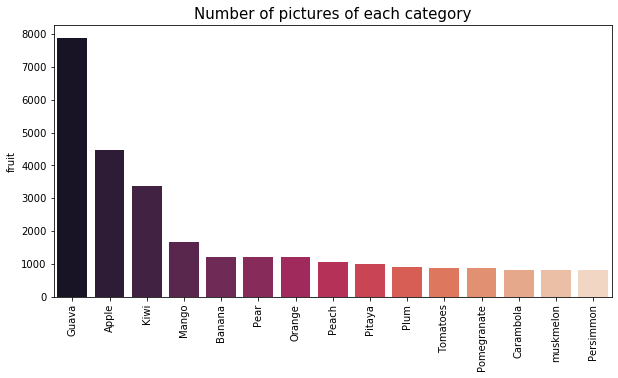

In [22]:
# Display the number of pictures of each category
# value_counts() return a Series containing counts of unique values in descending order so that the first element is the most frequently-occurring element
fruit_valueCounts = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fruit_valueCounts.index, y = fruit_valueCounts, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Display some pictures of the dataset
# fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(df.path[i]))
#     ax.set_title(df.fruit[i], fontsize = 12)
# plt.tight_layout(pad=0.0)
# plt.show()

In [24]:
# Resizing images is a critical preprocessing step in computer vision. 
# Principally, our machine learning models train faster on smaller images. 
# An input image that is twice as large requires our network to learn from four times as many pixels — and that time adds up. 
# Moreover, many deep learning model architectures require that our images are the same size and our raw collected images may vary in size.

def load_img(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [25]:
# # Function to slice the dataset and seperate dataset into training data.
# Return a part of the dataframe
# For example, if a dataframe has 10 rows and we want to return a part of them
# if it is cut in two, it will return the first 5 rows or the last 5 rows depending the part wanted

def cut_df(df, number_of_parts, part):
# Args:
#     df (pandas.DataFrame): The dataframe to cut a part of
#     number_of_parts (int): In how many parts should the dataframe be cut
#     part (int): The part of the dataframe to return

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
#     idx1 = (part-1) * number_imgs_each_part 
    idx2 = part * number_imgs_each_part
    return df.iloc[:idx2]

In [26]:
# We will be using Sequential() for image classification here.
# The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) 
# with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. 
# There's a fully-connected layer (tf.keras.layers.Dense) with 256 units on top of it 
# that is activated by a ReLU activation function ('relu'). 

def create_model():
    shape_img = (150,150,3) #image_height, image_width, color_channels ---image format
    
    #instance a Sequential model
    classifier = Sequential()
    
    classifier.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    
    classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    classifier.add(Flatten())

    # Dense(256) is a fully connected layer with 256 hidden neurons.
    classifier.add(Dense(256))
    classifier.add(Activation('relu'))
    # Dropput() to prevent overfitting.
    classifier.add(Dropout(0.5))
    
    # last layer has n=len(mapper_fruit_names)) dense. Has n output classes.
    classifier.add(Dense(len(mapper_fruit_names))) 
    classifier.add(Activation('softmax'))

    classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', 'recall'])
    
    return classifier

In [27]:
%%time

# Construct train, validation and test data
train_set , test_set = train_test_split(df,test_size=0.2,random_state=17)

train_gen = ImageDataGenerator(validation_split=0.1)
test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 'path',
    y_col = 'label',
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

val_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 'path',
    y_col = 'label',
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation'
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 'path',
    y_col = 'label',
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False
)

Found 20309 validated image filenames belonging to 15 classes.
Found 2256 validated image filenames belonging to 15 classes.
Found 5642 validated image filenames belonging to 15 classes.
CPU times: user 311 ms, sys: 593 ms, total: 904 ms
Wall time: 996 ms


In [28]:
%%time

# Building the sequential model
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)), 
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='softmax')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='categorical_crossentropy',
    metrics=['accuracy','Recall']
)

model.summary()

2022-03-13 18:05:58.171702: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
history = model.fit(train_data,epochs=50,validation_data=val_data)

Epoch 1/40
635/635 [==============================] - 2111s 3s/step - loss: 3.7370 - accuracy: 0.2501 - recall: 0.1837 - val_loss: 1.7841 - val_accuracy: 0.4464 - val_recall: 0.3573
Epoch 2/40
635/635 [==============================] - 2917s 5s/step - loss: 2.5541 - accuracy: 0.3764 - recall: 0.2872 - val_loss: 1.3957 - val_accuracy: 0.5638 - val_recall: 0.4526
Epoch 3/40
635/635 [==============================] - 6316s 10s/step - loss: 2.0258 - accuracy: 0.4588 - recall: 0.3542 - val_loss: 1.1800 - val_accuracy: 0.6192 - val_recall: 0.4947
Epoch 4/40
635/635 [==============================] - 4325s 7s/step - loss: 1.6665 - accuracy: 0.5232 - recall: 0.4175 - val_loss: 0.9901 - val_accuracy: 0.6919 - val_recall: 0.5426
Epoch 5/40
635/635 [==============================] - 3099s 5s/step - loss: 1.4302 - accuracy: 0.5787 - recall: 0.4676 - val_loss: 0.8729 - val_accuracy: 0.7305 - val_recall: 0.5944
Epoch 6/40
635/635 [==============================] - 2298s 4s/step - loss: 1.2528 - accu

KeyboardInterrupt: 

In [ ]:
def from_categorical(lst):
    """
    Inverse of to_categorical
    Example: [[0,0,0,1,0], [1,0,0,0,0]] => [3,0]
    """
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

In [ ]:
def display_stats(y_test, pred):
# Display prediction statistics
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")

In [ ]:
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [ ]:
model = create_model()
hists = []

divisor = 5

start_time = time.time()
# X_train, y_train = load_img(cut_df(df,divisor,1))
X, y = load_img(df)
X = X/255
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)
# train_df,test_df = train_test_split(df[['path','fruit']].sample(frac=0.05,random_state=0), test_size=0.2,random_state=0)
# Converts a class vector (integers) to binary class matrix. 
# A binary matrix representation of the input (y_train), which can be used with categorical_crossentropy
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)

# If the model doesn't increase its prediction accuracy on the validation data after 
# 20 epochs, stop the training and take the best MODEL.

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=128, epochs=5, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)

In [ ]:
Run the garbage collector
gc.collect()

In [ ]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")